In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mlxtend.data import loadlocal_mnist
import pickle

In [2]:
def fn_split(data, size):
    t = list(range(data.shape[0]))
    np.random.shuffle(t)
    return data[t[:int(size*data.shape[0])]], data[t[int(size*data.shape[0]):]]

def fetch():

    X_train, Y_train = loadlocal_mnist(
        images_path='../data/mnist/train-images-idx3-ubyte', labels_path='../data/mnist/train-labels-idx1-ubyte')
    X_test, Y_test = loadlocal_mnist(
    images_path='../data/mnist/t10k-images-idx3-ubyte', labels_path='../data/mnist/t10k-labels-idx1-ubyte')

    X_train_new = np.empty((len(X_train), 784))
    for i in range(0, len(X_train)):
        X_train_new[i] = np.ravel(X_train[i])
        
    Y_train = Y_train.reshape((60000, 1))
    
    # print(Y_train.shape)
        
    X_test_new = np.empty((len(X_test), 784))
    for i in range(0, len(X_test)):
        X_test_new[i] = np.ravel(X_test[i])
        
    Y_test = Y_test.reshape((10000, 1))
    
    
    X_train_new = X_train_new.reshape((60000, 784))
    X_test_new = X_test_new.reshape((10000, 784))
    data = np.append(X_train_new, X_test_new, axis = 0)
    labels = np.append(Y_train, Y_test, axis = 0)
    
    final_data = np.append(data, labels, axis=1)
    
    train, val = fn_split(final_data, 0.7)
    val, test = fn_split(val, 0.66)
    train, train_labels = train[:, :-1], train[:,-1:]
    val, val_labels = val[:, :-1], val[:,-1:]
    test, test_labels = test[:, :-1], test[:,-1:]
    
    
    return train, train_labels, test, test_labels, val, val_labels
        
X_train, Y_train, X_test, Y_test, X_val, Y_val =  fetch()
# print(X_train.shape)
# print(Y_train.shape)

In [3]:
Y_train.shape

(49000, 1)

In [4]:
class NeuralNetwork:

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
        self.n_layers = n_layers
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.weight_init = weight_init
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        
    
    def initializeWeights(self):
        
        layers = self.layer_sizes
        # total_layers = len(self.layer_sizes)
        params = {}
        
        L = self.n_layers
        
        for i in range(0, L-1):
            
            curr_layer = None
            
            if (self.weight_init == "zero"):
                curr_layer = np.zeros((layers[i], layers[i+1]))
                
            elif (self.weight_init == "random"):
                curr_layer = np.random.randn(layers[i], layers[i+1])*0.01
                
            elif (self.weight_init == "normal"):
                curr_layer = np.random.normal(size = (layers[i], layers[i+1]))*0.01
                
            params["W" + str(i+1)] = curr_layer
            params["b" + str(i+1)] = np.zeros((1,layers[i+1]))

        self.parameters = params
            
        return params
        
    def activation_func(self, z):
        
        if (self.activation == "ReLU"):
            return (z * (z>=0))
            
        elif (self.activation == "Leaky ReLU"):
            return np.where(z > 0, z, z * 0.01)
            
        elif (self.activation == "sigmoid"):
            return (1.0/(1+np.exp(-z)))
        
        elif (self.activation == "linear"):
            return z
            
        elif (self.activation == "tanh"):
            return np.tanh(z)
            
        elif (self.activation == "softmax"):
            return np.exp(z) / np.sum(np.exp(z), axis=0)
        
    def activation_grad(self, y, activation="linear"):
        
        if (self.activation == "ReLU"):
            return 1*(y>=0)
            
        elif (self.activation == "Leaky ReLU"):
            dy = np.ones_like(y)
            dy[y < 0] = 0.01
            return dy
            
        elif (self.activation == "sigmoid"):
            return self.activation_func(y) * (1-self.activation_func(y))
        
        elif (self.activation == "linear"):
            return np.ones(y.shape)
            
        elif (self.activation == "tanh"):
            return self.activation_func(y) * (1-self.activation_func(y))
            
        elif (self.activation == "softmax"):
            return self.activation_func(y) * (1-self.activation_func(y))
        
    
    def forward_propogation(self, X, params):
        
        caches = {}
        A = X
        
        # print(X.shape)
        
        L = len(params)//2
        
        for i in range(0, L-1):
            
            A_prev = A
            Z = np.dot(A_prev, params["W" + str(i+1)]) + params["b" + str(i+1)]
            
            A = self.activation_func(Z)
            
            caches[str(i+1)] = (Z, A)
            A_prev = A
            
        Z_l = np.dot(A_prev, params["W" + str(L)]) + params["b" + str(L)]
        A_l = self.activation_func(Z_l)
        
        caches[str(L)] = (Z_l, A_l)
        
        return A_l, caches    
        
    
    def backward_propogation(self, X, Y, caches):
        
        grads = {}
        
        L = self.n_layers - 1
        Lx = len(X)
        caches[str(0)] = (X, X)
        
        A = caches[str(L)][1]
        
        dZ = A-Y
        
        dW = np.dot(caches[str(L-1)][1].T, dZ) / Lx
        db = np.sum(dZ, axis=0, keepdims=True) / Lx
        
        dA_prev = np.dot(dZ, self.parameters["W" + str(L)].T)
        
        grads["dW" + str(L)] = dW
        grads["db" + str(L)] = db
        
        for i in range(L - 1, 0, -1):
            d_act = self.activation_grad(caches[str(i)][0])
            
            # print(dA_prev.shape)
            # print(d_act.shape)
            # dZ = np.matmul(dA_prev, d_act)
            dZ = dA_prev * d_act
            # print(dZ)
            dW = np.dot(caches[str(i-1)][1].T, dZ) / Lx
            db = np.sum(dZ, axis=0, keepdims=True) / Lx
            
            if i > 1:
                dA_prev = np.dot(dZ, self.parameters["W" + str(i)].T)

            grads["dW" + str(i)] = dW
            grads["db" + str(i)] = db
                
        self.update_weights(grads)        
        
        return grads
    
    
    def update_weights(self, grads):
        
        L = self.n_layers
        
        for i in range(0, L-1):
            self.parameters["W" + str(i+1)] = self.parameters["W" + str(i+1)] - self.learning_rate * grads["dW" + str(i+1)]
            self.parameters["b" + str(i+1)] = self.parameters["b" + str(i+1)] - self.learning_rate * grads["db" + str(i+1)]
            
            
    def labels_to_class(self, y):
        m = len(y)
        c = int(np.max(y))
        y_classes = np.zeros((m,c+1))
        for i in range(m):
            l = int(y[i])
            y_classes[i,l] = 1

        return y_classes
                    
        
      
    def fittt(self, X, y , x_test=None, y_test=None):
        y = self.labels_to_class(y)
        
        m , n_0 = X.shape
        n_l = y.shape[1]

        parameters = self.initializeWeights()
        self.parameters = parameters

        train_loss_history = []
        train_accuracy_history = []
        test_loss_history = []
        test_accuracy_history = []

        

        for epoch in tqdm(range(self.num_epochs), desc = "Progress Total : ", position = 0, leave = True):


            n_batches = m//self.batch_size
            X_batches = [X[self.batch_size*i:self.batch_size*(i+1),:] for i in range(0,n_batches)]
            y_batches = [y[self.batch_size*i:self.batch_size*(i+1),:] for i in range(0,n_batches)]

            train_batch_loss = []
            test_batch_loss = []
            train_batch_accuracy = []
            test_batch_accuracy = []

            for curr_x, curr_y in tqdm(zip(X_batches,y_batches), desc = "Progress Epoch: " + str(epoch+1) + "/" + str(self.num_epochs), position = 0, leave = True, total = len(X_batches)):
                A, caches = self.forward_propogation(curr_x,parameters)

                train_cost = self.cross_entropy_loss(A,curr_y)
                train_batch_loss.append(train_cost)
#                 print(A)
                self.backward_propogation(curr_x,curr_y, caches)
#                 train_batch_accuracy.append(self.score(curr_x,np.argmax(curr_y,axis = 1)))
                if(x_test is not None):
                    proba = self.predict_proba(x_test)
#                     print(proba.shape)
                    test_loss = self.cross_entropy_loss(proba, self.labels_to_class(y_test))
                    test_batch_loss.append(test_loss)
#                     test_batch_accuracy.append(self.score(x_test, y_test))
                    
#             print("Training Accuracy : ", np.array(train_batch_accuracy).mean())
#             print("Validation Accuracy : ", np.array(test_batch_accuracy).mean())
            print("Testing loss : " ,np.array(test_batch_loss).mean())
            print("Training Loss : ", np.array(train_batch_loss).mean())
            


            train_loss_history.append( np.array(train_batch_loss).mean())
#             train_accuracy_history.append( np.array(train_batch_accuracy).mean())
            test_loss_history.append( np.array(test_batch_loss).mean())
#             test_accuracy_history.append(  np.array(test_batch_accuracy).mean())
                
                
        
        self.train_loss_history = train_loss_history
        self.train_accuracy_history = train_accuracy_history
        self.test_loss_history = test_loss_history
        self.test_accuracy_history = test_accuracy_history
        
        
        self.parameters = parameters


        return self  
        
        
    def fit (self, X_train, Y_train, X_val, Y_val):
        
        Y_train = self.labels_to_class(Y_train)
        
        m = X_train.shape[0]
        no_batches = m//self.batch_size
        datas=[]
        for subset in range(0,no_batches):
            mini_X = X_train[self.batch_size*subset : self.batch_size*(subset+1), :]
            mini_Y = Y_train[self.batch_size*subset : self.batch_size*(subset+1), :]
            datas.append((mini_X,mini_Y))
        
        
        print(X_train.shape)
        print(Y_train.shape)
        print(X_test.shape)
        print(Y_test.shape)
        
        params = self.initializeWeights()
        
        self.parameters = params
        
        train_loss = []
        val_loss = []
      
        for epoch in range(1, self.num_epochs+1):
            print("Epoch: ", epoch)
            trainbatchloss = []
            valbatchloss = []

            for x_b, y_b in datas:
                A_l, caches = self.forward_propogation(x_b,self.parameters)
                train_cost = self.cross_entropy_loss(A_l, y_b)
                trainbatchloss.append(train_cost)
                self.backward_propogation(x_b,y_b, caches)
                proba = self.predict_proba(X_val)
                valloss = self.cross_entropy_loss(proba, self.labels_to_class(Y_val))
                valbatchloss.append(valloss)

            
            l1 = np.array(trainbatchloss).mean()
            l2 = np.array(valbatchloss).mean()


            train_loss.append(l1)
            val_loss.append(l2)
            
            print("Training loss : " ,l1)
            print("Validation Loss : ", l2)
              
              
      
        self.train_loss = train_loss
        self.val_loss = val_loss
        self.parameters = params
  
    
     
    def cross_entropy_loss(self, A_l, y_test):
        
        temp=A_l[np.arange(len(y_test)), y_test.argmax(axis=1)]
        temp=np.where(temp>0.0000000000001,temp,0.000000000001)
        logp = - np.log(temp)
        celoss = np.sum(logp)/len(y_test)
        return celoss
        
        
        # m = len(y_test)
        
        # # logprods = np.dot(y_test, np.log(A_l).T) + np.dot((1-y_test), np.log(1-A_l).T)
        # # cost = -1/n*np.sum(logprods)
        
        # logp = - np.log(1e-7 + A_l[np.arange(m), y_test.argmax(axis=1)])
        # loss = np.sum(logp)/m
        # return loss 
            
    def predict_proba(self, X):
        
        prob, caches = self.forward_propogation(X, self.parameters)
        
        return prob
    
    def predict(self, X):
        
        prob = self.predict_proba(X)
        Y_prediction = np.argmax(prob, axis = 1)
        return Y_prediction
    
    def score(self, X, Y):
        Y_prediction = self.predict(X)
        count = 0
        for i in range(len(Y)):    
            if (Y_prediction[i] == Y[i]):
                count+=1
        return count/len(Y)
        
        # acc = (Y_prediction == Y)
        # return acc.sum()/len(Y)
    

### ReLU

In [5]:
nn = NeuralNetwork(6, [784,256, 128, 64, 32,10], 'ReLU', 0.08, 'normal', 128, 25)


nn.fit(X_train, Y_train, X_val, Y_val)

print("Accuracy - " + str(nn.score(X_test,Y_test)))

(49000, 784)
(49000, 10)
(7140, 784)
(7140, 1)
Epoch:  1
Training loss :  1.9081959507032578
Validation Loss :  1.863081833284685
Epoch:  2
Training loss :  0.5198651888937658
Validation Loss :  0.5429911548115297
Epoch:  3
Training loss :  0.2734888337143587
Validation Loss :  0.3156503069958717
Epoch:  4
Training loss :  0.19919327875371323
Validation Loss :  0.2575729890680966
Epoch:  5
Training loss :  0.14571079918241853
Validation Loss :  0.23383034941881442
Epoch:  6
Training loss :  0.1115411957273145
Validation Loss :  0.22591217346075423
Epoch:  7
Training loss :  0.08970763518102691
Validation Loss :  0.22240872799646325
Epoch:  8
Training loss :  0.06942959855372913
Validation Loss :  0.22334251832785323
Epoch:  9
Training loss :  0.054767271379371214
Validation Loss :  0.22501473141428494
Epoch:  10
Training loss :  0.041256275664719295
Validation Loss :  0.2257547314806528
Epoch:  11
Training loss :  0.032171489604878346
Validation Loss :  0.2297102193518678
Epoch:  12
Tr

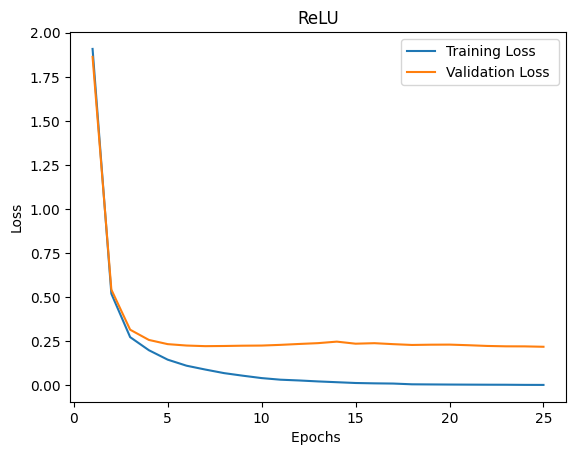

In [6]:

plt.plot([x for x in range(1,len(nn.train_loss) + 1, 1)],nn.train_loss, label = "Training Loss " )
plt.plot([x for x in range(1,len(nn.val_loss) + 1, 1)],nn.val_loss, label = "Validation Loss " )
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.legend()
plt.title("ReLU")
plt.show()
    

In [7]:
import pickle
file = open("Weights/ReLU", "wb")
pickle.dump(nn, file)
file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'Weights/ReLU'

### Leaky ReLU

In [ ]:
nn2 = NeuralNetwork(6, [784,256, 128, 64, 32,10], 'Leaky ReLU', 0.08, 'normal', 128, 25)


nn2.fit(X_train, Y_train, X_val, Y_val)

print("Accuracy - " + str(nn2.score(X_test,Y_test)))

In [ ]:
import pickle

plt.plot([x for x in range(1,len(nn2.train_loss) + 1)],nn2.train_loss, label = "Training Loss " )
plt.plot([x for x in range(1,len(nn2.val_loss) + 1)],nn2.val_loss, label = "Validation Loss " )
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.legend()
plt.title("Leaky ReLU")
plt.show()

file = open("Weights/Leaky_ReLU", "wb")
pickle.dump(nn2, file)
file.close()

### Sigmoid

In [ ]:
nn3 = NeuralNetwork(6, [784,256, 128, 64, 32,10], 'sigmoid', 0.08, 'normal', 128, 25)
nn3.fit(X_train, Y_train, X_val, Y_val)
print("Accuracy - " + str(nn3.score(X_test,Y_test)))

In [ ]:
import pickle

plt.plot([x for x in range(1,len(nn3.train_loss) + 1)],nn3.train_loss, label = "Training Loss " )
plt.plot([x for x in range(1,len(nn3.val_loss) + 1)],nn3.val_loss, label = "Validation Loss " )
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.legend()
plt.title("sigmoid")
plt.show()

file = open("Weights/sigmoid", "wb")
pickle.dump(nn3, file)
file.close()

### tanh

In [ ]:
nn4 = NeuralNetwork(6, [784,256, 128, 64, 32,10], 'tanh', 0.08, 'normal', 128, 25)
nn4.fit(X_train, Y_train, X_val, Y_val)
print("Accuracy - " + str(nn4.score(X_test,Y_test)))

In [ ]:
import pickle

plt.plot([x for x in range(1,len(nn4.train_loss) + 1)],nn4.train_loss, label = "Training Loss " )
plt.plot([x for x in range(1,len(nn4.val_loss) + 1)],nn4.val_loss, label = "Validation Loss " )
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.legend()
plt.title("tanh")
plt.show()

file = open("Weights/tanh", "wb")
pickle.dump(nn4, file)
file.close()

### Linear

In [ ]:
nn5 = NeuralNetwork(6, [784,256, 128, 64, 32,10], 'linear', 0.08, 'normal', 128, 25)
nn5.fit(X_train, Y_train, X_val, Y_val)
print("Accuracy - " + str(nn5.score(X_test,Y_test)))

In [ ]:
plt.plot([x for x in range(1,len(nn5.train_loss) + 1)], nn5.train_loss, label = "Training Loss " )
plt.plot([x for x in range(1,len(nn5.val_loss) + 1)], nn5.val_loss, label = "Validation Loss " )
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.legend()
plt.title("linear")
plt.show()

file = open("Weights/linear", "wb")
pickle.dump(nn5, file)
file.close()

### Softmax

In [ ]:
nn6 = NeuralNetwork(6, [784,256, 128, 64, 32,10], 'softmax', 0.08, 'normal', 128, 25)
nn6.fit(X_train, Y_train, X_val, Y_val)
print("Accuracy - " + str(nn6.score(X_test,Y_test)))

In [ ]:
plt.plot([x for x in range(1,len(nn6.train_loss) + 1)], nn6.train_loss, label = "Training Loss " )
plt.plot([x for x in range(1,len(nn6.val_loss) + 1)], nn6.val_loss, label = "Validation Loss " )
plt.xlabel('Epochs ')
plt.ylabel('Loss')
plt.legend()
plt.title("softmax")
plt.show()

file = open("Weights/softmax", "wb")
pickle.dump(nn6, file)
file.close()

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
clf1 = MLPClassifier(solver='lbfgs', alpha=0.08, hidden_layer_sizes=(256,128,64,32), random_state=1, activation = 'relu', max_iter=150, batch_size=200)
clf1.fit(X_train, Y_train.ravel())

In [ ]:
score1 = clf1.score(X_test,Y_test)
print("ReLU Accuracy : ", score1)

In [ ]:
clf2 = MLPClassifier(solver='lbfgs', alpha=0.08, hidden_layer_sizes=(256,128,64,32), random_state=1, activation = 'logistic', max_iter=150, batch_size=200)
clf2.fit(X_train, Y_train.ravel())

In [ ]:
score2 = clf2.score(X_test,Y_test)
print("sigmoid Accuracy : ", score2)

In [ ]:
clf3 = MLPClassifier(solver='lbfgs', alpha=0.08, hidden_layer_sizes=(256,128,64,32), random_state=1, activation = 'tanh', max_iter=150, batch_size=200)
clf3.fit(X_train, Y_train.ravel())

In [ ]:
score3 = clf3.score(X_test,Y_test)
print("Tanh Accuracy : ", score3)

In [ ]:
clf4 = MLPClassifier(solver='lbfgs', alpha=0.08, hidden_layer_sizes=(256,128,64,32), random_state=1, activation = 'identity', batch_size=200)
clf4.fit(X_train, Y_train.ravel())

In [ ]:
score4 = clf4.score(X_test,Y_test)
print("Linear Accuracy : ", score4)